In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import Activation
import keras
import tensorflow
import seaborn as sns
from sklearn.metrics import mean_squared_error


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
#from google.colab import files  
#uploaded = files.upload()

In [3]:
#import io
#Data=pd.read_csv(io.BytesIO(uploaded['NIFTY50 - NIFTY50.csv']))

In [4]:
Data=pd.read_csv("C:\\Users\\anish\\OneDrive\\Desktop\\Stock Predictor\\LSMT model\\NIFTY50 - NIFTY50.csv")

In [5]:
cols= list(Data)[1:5]
stock_prices = Data[cols].astype(float)

# Normalizing Data

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(stock_prices)
stock_prices_scaled = scaler.transform(stock_prices)
print('df_for_training_scaled shape == {}.'.format(stock_prices_scaled.shape))

df_for_training_scaled shape == (3326, 4).


# Test Train Data Split

In [7]:
train_size = int(len(stock_prices_scaled) * 0.66)
test_size = len(stock_prices_scaled) - train_size
train, test = stock_prices_scaled[0:train_size,:], stock_prices_scaled[train_size:len(stock_prices_scaled),:]


# Input Label Splitter:


In [8]:
train_inputs = []
train_closing_labels=[]

In [9]:
n_future = 1   # Number of days we want to predict into the future
n_past = 14   # Number of past days we want to use to predict the future
for i in range(n_past, len(train) - n_future +1):
    train_inputs.append(train[i - n_past:i, 0:train.shape[1]])
    #train_opening_labels.append(train[i + n_future - 1:i + n_future, 0])
    train_closing_labels.append(train[i + n_future - 1:i + n_future, 1])
train_inputs, train_closing_labels = np.array(train_inputs), np.array(train_closing_labels)


In [10]:
print('train_input shape == {}.'.format(train_inputs.shape))
print('train_closing shape == {}.'.format(train_closing_labels.shape))

train_input shape == (2181, 14, 4).
train_closing shape == (2181, 1).


# Training The Data using Stacked LSTM

In [11]:
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(train_inputs.shape[1], train_inputs.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))
#model.add(Dense(32))
model.add(Dense(train_closing_labels.shape[1]))
#model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 14, 128)           35328     
_________________________________________________________________
dropout (Dropout)            (None, 14, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 76,609
Trainable params: 76,609
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(train_inputs, train_closing_labels, epochs = 100, validation_data = (train_inputs, train_closing_labels), batch_size = 32, verbose=1)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmph77v9fl6.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmph77v9fl6.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - 48s 100ms/step - loss: 0.2274 - val_loss: 0.0041
Epoch 2/100
69/69 [==============================] - 3s 42ms/step - loss: 0.0122 - val_loss: 0.0042
Epoch 3/100
69/69 [==============================] - 4s 51ms/step - loss: 0.0110 - val_loss: 0.0038
Epoch 4/100
69/69 [==============================] - 3s 45ms/step - loss: 0.0111 - val_loss: 0

# Checking the predictions of training data

In [38]:
training_data_prediction= model.predict(train_inputs) 

In [39]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies_1 = np.repeat(training_data_prediction, train.shape[1], axis=-1)
predicted_train = scaler.inverse_transform(forecast_copies_1)[:,0]
#predicted_train

In [40]:
Train_data=Data[n_past:train_size]
Train_data['Date']=pd.to_datetime(Train_data['Date'])
training_forecast = pd.DataFrame( {'Date':Train_data['Date'],'Close':Train_data['Close'],'Forecast':predicted_train})
train_graph=training_forecast.set_index('Date')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Plotting the actual close price and predicted close price of training sample

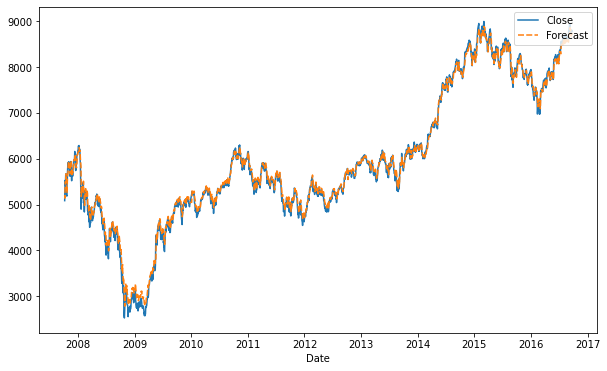

In [41]:
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=train_graph)
ax.legend (loc="upper right")

# Finding the training error, bias

In [42]:
import math
trainScore = math.sqrt(mean_squared_error(train_graph['Close'], train_graph['Forecast']))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 105.69 RMSE


In [43]:
test_inputs=[]
for i in range(n_past, len(test) - n_future +1):
    test_inputs.append(test[i - n_past:i, 0:train.shape[1]])
test_inputs=np.array(test_inputs)

In [44]:
testing_data_prediction= model.predict(test_inputs) 
forecast_copies_2 = np.repeat(testing_data_prediction, test.shape[1], axis=-1)
predicted_test = scaler.inverse_transform(forecast_copies_2)[:,0]

In [45]:
Test_data=Data[train_size+n_past:len(stock_prices_scaled)]
Test_data['Date']=pd.to_datetime(Test_data['Date'])
testing_forecast = pd.DataFrame( {'Date':Test_data['Date'],'Close':Test_data['Close'],'Forecast':predicted_test})
test_graph=testing_forecast.set_index('Date')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


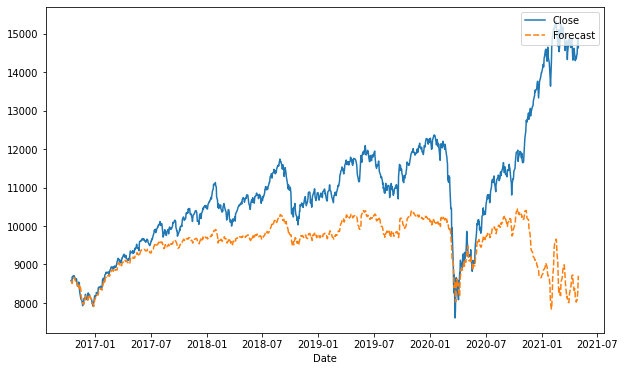

In [46]:
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=test_graph)
ax.legend (loc="upper right")

In [ ]:
import math
testScore = math.sqrt(mean_squared_error(test_graph['Close'], test_graph['Forecast']))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 1470.30 RMSE
